In [172]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.3.1


In [192]:
%matplotlib inline

In [193]:
def read_dataset_x_y1_y2(images_directory_path):
    dataset = []
    for path, sub_dirs, files in os.walk(images_directory_path):
        for name in files:
            file_path = os.path.join(path, name)
            x = cv2.imread(file_path)        
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
            y1 = path.split('\\')[-1]
            y2 = name.split('_')[0]
            dataset.append([np.array(x), y1, y2])
    return dataset

In [194]:
def read_age_dataset_y2(dataset, xlsx_age_dataset, columns, label_column, y2_column):
    age_dataframe = pd.read_excel(xlsx_age_dataset)
    age_dataframe = age_dataframe[columns]
    age_dataframe.dropna(inplace=True)
    for i in range(len(dataset)):
        dataset[i][-1] = age_dataframe.loc[age_dataframe[label_column] == dataset[i][-1]][y2_column].values[0]
    return np.array(dataset)

In [195]:
images_directory_path = "dataset\labeledframes"
xlsx_age_dataset = "dataset\OrginalDatabase\summaryParticipansts.xlsx"

dataset = read_dataset_x_y1_y2(images_directory_path)
columns = ["Sr. No", "Age"]
label_column = "Sr. No"
y2_column = "Age"
dataset = read_age_dataset_y2(dataset, xlsx_age_dataset, columns, label_column, y2_column)


In [196]:
X = dataset[:,0]
X.shape

(1080,)

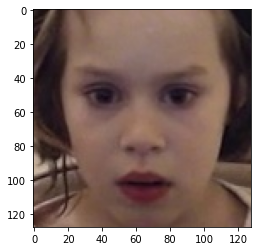

In [197]:
plt.imshow(X[-1])

In [198]:
y1 = dataset[:,1]
y1.shape

(1080,)

In [199]:
y2 = np.array(dataset[:,2], dtype="float")
y2.shape

(1080,)

In [200]:
img_w = 128
img_h = 128
n_classes = 7

In [201]:
expression_Label_encoder = LabelEncoder()
y1 = expression_Label_encoder.fit_transform(y1)
y1

array([0, 0, 0, ..., 6, 6, 6])

In [202]:
from collections import Counter

counter = Counter(y1)
print(expression_Label_encoder.classes_)
print(counter)

['anger' 'confusing' 'disgust' 'fear' 'happy' 'sad' 'surprise']
Counter({4: 342, 3: 249, 6: 226, 5: 208, 2: 44, 1: 7, 0: 4})


In [203]:
import random

def downsample_dataset(X, y1, y2, n_classes, num_samples_per_class):
    X_list = []
    y1_list = []
    y2_list = []
    for i in range(n_classes):
        y1_index_temp = [j for j in range(y1.shape[0]) if y1[j]==i]
        y1_index_temp = random.sample(y1_index_temp, num_samples_per_class)
        
        X_temp = X[y1_index_temp]
        y1_temp = y1[y1_index_temp]
        y2_temp = y2[y1_index_temp]
        
        X_list.extend(X_temp)
        y1_list.extend(y1_temp)
        y2_list.extend(y2_temp)
        
    return X_list, y1_list, y2_list

In [204]:
X_temps, y1_temps, y2_temps = downsample_dataset(X, y1, y2, n_classes, 4)
X, y1, y2 = X_temps, y1_temps, y2_temps

In [205]:
y1 = np_utils.to_categorical(y1)
y1

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
 

In [206]:
X[0]

array([[[107,  91, 120],
        [ 99,  84, 113],
        [ 91,  76, 105],
        ...,
        [154,  53,  33],
        [160,  57,  38],
        [163,  60,  41]],

       [[102,  86, 115],
        [ 95,  80, 109],
        [ 88,  73, 102],
        ...,
        [157,  56,  36],
        [163,  60,  41],
        [165,  62,  43]],

       [[100,  84, 111],
        [ 93,  79, 105],
        [ 86,  71, 100],
        ...,
        [157,  56,  38],
        [162,  59,  42],
        [163,  60,  43]],

       ...,

       [[108, 113, 142],
        [119, 124, 153],
        [114, 119, 148],
        ...,
        [ 67,  48,  44],
        [ 62,  41,  36],
        [ 62,  41,  36]],

       [[101, 108, 136],
        [118, 125, 153],
        [111, 118, 146],
        ...,
        [ 64,  46,  42],
        [ 59,  40,  34],
        [ 58,  39,  33]],

       [[101, 108, 136],
        [120, 127, 155],
        [111, 118, 146],
        ...,
        [ 62,  44,  40],
        [ 58,  39,  33],
        [ 57,  38,  32]]

In [207]:
def convert_to_gray_scale(images):
    list_images = []
    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        list_images.append(image)
    return list_images

(129, 129)
['anger' 'confusing' 'disgust' 'fear' 'happy' 'sad' 'surprise']
[0. 0. 0. 0. 0. 1. 0.]
4.0


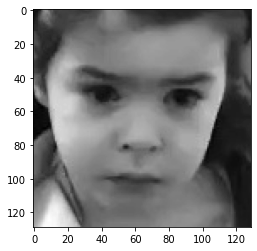

In [208]:
gray_sclaed_images = convert_to_gray_scale(X)
print(gray_sclaed_images[-1].shape)
plt.imshow(gray_sclaed_images[-7], cmap='gray')
X = gray_sclaed_images
print(expression_Label_encoder.classes_)
print(y1[-7])
print(y2[-7])

In [209]:
def resize_image(images, img_w, img_h):
    images_list = []
    for image in images:
        image = cv2.resize(image, (img_w, img_h))
        images_list.append(image)
    return np.array(images_list)

In [210]:
X = resize_image(X, img_w, img_h)
X = np.array(X, dtype="float") / 255.0
X.shape

(28, 128, 128)

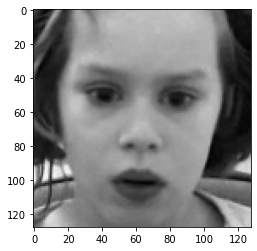

In [211]:
plt.imshow(X[-1], cmap="gray")

In [212]:
VARIABILITY = 10

In [213]:
def add_noise(img):
    deviation = VARIABILITY * np.random.random()
    noise = 0.01 * np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.clip(img, 0, 1)
    return img

In [214]:
def increase_with_noise(X_org, y1_org, y2_org):
    noisy_X = []
    noisy_y1 = []
    noisy_y2 = []
    for image, label1, label2 in zip(X_org, y1_org, y2_org):
        noise_image = add_noise(image)
        noisy_X.append(noise_image)
        noisy_y1.append(label1)
        noisy_y2.append(label2)
    return noisy_X, noisy_y1, noisy_y2

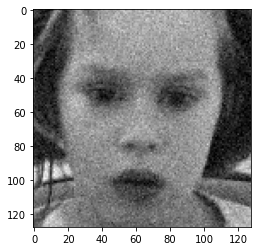

In [215]:
noisy_X, noisy_y1, noisy_y2 = increase_with_noise(X, y1, y2)
plt.imshow(noisy_X[-1], cmap='gray')

In [216]:
X = np.vstack((X, noisy_X))
y1 = np.vstack((y1, noisy_y1))
y2 = np.hstack((y2, noisy_y2))
print(X.shape)
print(y1.shape)
print(y2.shape)

(56, 128, 128)
(56, 7)
(56,)


In [217]:
X[0]

array([[0.36749041, 0.30719657, 0.28902782, ..., 0.33506687, 0.29387366,
        0.35350926],
       [0.33626953, 0.28329788, 0.26994199, ..., 0.33945975, 0.33325264,
        0.34679033],
       [0.31267736, 0.2713711 , 0.24260005, ..., 0.35221962, 0.33934189,
        0.33731408],
       ...,
       [0.48977527, 0.46267195, 0.43249849, ..., 0.1171374 , 0.19599763,
        0.19638345],
       [0.47995944, 0.46806779, 0.44521101, ..., 0.14742491, 0.20981528,
        0.18977365],
       [0.46814091, 0.4701849 , 0.43665111, ..., 0.14487498, 0.19202664,
        0.18941375]])

In [218]:
X = np.array(X).reshape((-1, img_w, img_h, 1)).astype('float32')
y2 = np.array(y2)

In [219]:
train_X, test_X, train_y1, test_y1, train_y2, test_y2 = train_test_split(X, y1, y2, test_size=0.1, random_state=0, shuffle=True)

In [220]:
print("train_X.shape: ", train_X.shape)
print("train_y1.shape: ", train_y1.shape)
print("train_y2.shape: ", train_y2.shape)

train_X.shape:  (50, 128, 128, 1)
train_y1.shape:  (50, 7)
train_y2.shape:  (50,)


In [221]:
print("test_X.shape: ", test_X.shape)
print("test_y1.shape: ", test_y1.shape)
print("test_y2.shape: ", test_y2.shape)

test_X.shape:  (6, 128, 128, 1)
test_y1.shape:  (6, 7)
test_y2.shape:  (6,)


In [222]:
def build_model_1(img_w, img_h, n_classes):
    inputs = Input(shape=(img_h, img_w, 1))
    
    # 1 - Convolution
    cov_1 = Conv2D(64,(3,3), padding='same')(inputs)
    batch_n_1 = BatchNormalization()(cov_1)
    activation_1 = Activation('relu')(batch_n_1)
    maxpooling_1 = MaxPooling2D(pool_size=(2, 2))(activation_1)
    dropout_1 = Dropout(0.25)(maxpooling_1)\


    # 2 - Convolution
    cov_2 = Conv2D(128,(5,5), padding='same')(dropout_1)
    batch_n_2 = BatchNormalization()(cov_2)
    activation_2 = Activation('relu')(batch_n_2)
    maxpooling_2 = MaxPooling2D(pool_size=(2, 2))(activation_2)
    dropout_2 = Dropout(0.25)(maxpooling_2)

    
    # 3 - Convolution
    cov_3 = Conv2D(512,(3,3), padding='same')(dropout_2)
    batch_n_3 = BatchNormalization()(cov_3)
    activation_3 = Activation('relu')(batch_n_3)
    maxpooling_3 = MaxPooling2D(pool_size=(2, 2))(activation_3)
    dropout_3 = Dropout(0.25)(maxpooling_3)


    # 4 - Convolution
    cov_4 = Conv2D(512,(3,3), padding='same')(dropout_3)
    batch_n_4 = BatchNormalization()(cov_4)
    activation_4 = Activation('relu')(batch_n_4)
    maxpooling_4 = MaxPooling2D(pool_size=(2, 2))(activation_4)
    dropout_4 = Dropout(0.25)(maxpooling_4)


    flatten = Flatten()(dropout_4)
    dense = Dense(256)(flatten)
    batch_n = BatchNormalization()(dense)
    activation = Activation('relu')(batch_n)
    dropout = Dropout(0.25)(activation)

    # Fully connected layer 2nd layer
    dense = Dense(512)(dropout)
    batch_n = BatchNormalization()(dense)
    activation = Activation('relu')(batch_n)
    dropout = Dropout(0.25)(activation)
    dense = Dense(256)(dropout)
    
    classifier = Dense(n_classes, activation='softmax', name="classification")(dense)
    
    reg_dense_1 = Dense(256, activation='relu')(dense)
    regressor = Dense(1, activation='linear', name="regression")(reg_dense_1)
    
    return Model(inputs=inputs, outputs=[classifier, regressor])

In [223]:
def build_classifier(inputs, n_classes, finalAct="softmax", chanDim=-1):

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        x = Flatten()(x)
        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(n_classes)(x)
        x = Activation(finalAct, name="classification")(x)
        
        return x

In [224]:
def build_regressor(inputs, finalAct="linear", chanDim=-1):
    
        # CONV => RELU => POOL
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="regression")(x)
        return x

In [225]:
def build_model_2(width, height, n_classes):
        inputShape = (height, width, 1)
        chanDim = -1

        inputs = Input(shape=inputShape)
        
        classification = build_classifier(inputs, n_classes, finalAct="softmax", chanDim=chanDim)
        regression = build_regressor(inputs, finalAct="linear", chanDim=chanDim)
        
        model = Model(
            inputs=inputs,
            outputs=[classification, regression],
            name="clf_reg")
        
        return model

In [234]:
model = build_model_2(img_w, img_h, n_classes)
model.summary()

Model: "clf_reg"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 128, 128, 32) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 128, 128, 32) 128         activation_26[0][0]              
____________________________________________________________________________________________

In [235]:
losses = {
    'classification': 'categorical_crossentropy',
    'regression': 'mse',
}

loss_weights = {"classification": 1.0, 
                "regression": 1.0}


metrics = {'classification':'AUC', 
           'regression': 'mse'}

model.compile(loss=losses,
              loss_weights = loss_weights,
              optimizer='adam',
              metrics=metrics)

In [236]:
#EPOCHS = 15
EPOCHS = 50
BATCH_SIZE = 1
model_path_file = "model_weight.h5"

checkpoint = ModelCheckpoint(model_path_file, 
                             monitor='val_classification_auc', 
                             save_weights_only=False,
                             mode='max',
                             verbos=1)

reduce_lr = ReduceLROnPlateau(monitor='val_classification_loss', 
                             factor=0.1,
                             patience=2,
                             min_lr=0.00001, 
                             mode='auto')

callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

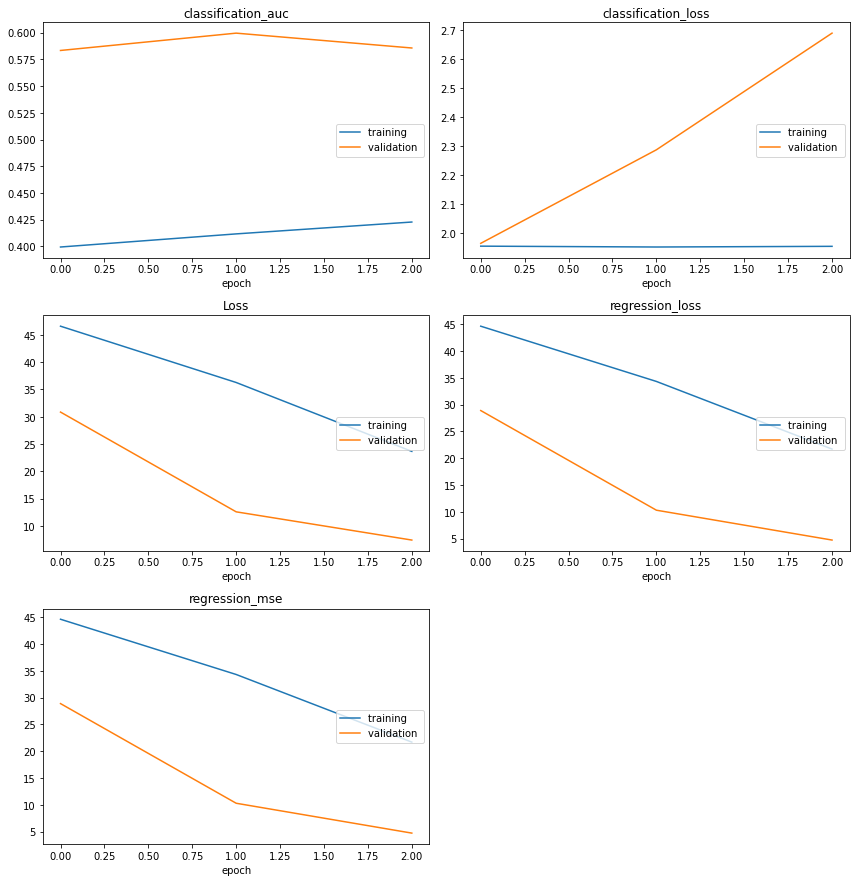

classification_auc
	training         	 (min:    0.399, max:    0.423, cur:    0.423)
	validation       	 (min:    0.583, max:    0.600, cur:    0.586)
classification_loss
	training         	 (min:    1.952, max:    1.955, cur:    1.955)
	validation       	 (min:    1.965, max:    2.691, cur:    2.691)
Loss
	training         	 (min:   23.664, max:   46.582, cur:   23.664)
	validation       	 (min:    7.430, max:   30.860, cur:    7.430)
regression_loss
	training         	 (min:   21.709, max:   44.626, cur:   21.709)
	validation       	 (min:    4.739, max:   28.895, cur:    4.739)
regression_mse
	training         	 (min:   21.709, max:   44.626, cur:   21.709)
	validation       	 (min:    4.739, max:   28.895, cur:    4.739)
50/50 [==============================] - 9s 176ms/step - loss: 23.6640 - classification_loss: 1.9546 - regression_loss: 21.7093 - classification_auc: 0.4228 - regression_mse: 21.7093 - val_loss: 7.4301 - val_classification_loss: 2.6907 - val_regression_loss: 4.7393

KeyboardInterrupt: 

In [237]:
history = model.fit(x=train_X,
                    y={"classification": train_y1, "regression": train_y2},
                    validation_data=(test_X,
                                     {"classification": test_y1, "regression": test_y2}),
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks=callbacks,
                    verbose=1)

In [238]:
from tensorflow.keras.models import load_model

model = load_model(model_path_file)

In [239]:
(yhat1, yhat2) = model.predict(train_X)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [240]:
model.evaluate(train_X, (train_y1, train_y2))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 0s 198ms/step - loss: 8.9555 - classification_loss: 3.0919 - regression_loss: 5.8636 - classification_auc: 0.5226 - regression_mean_squared_error: 5.8636


[8.955526351928711,
 3.091888427734375,
 5.863637924194336,
 0.5226333141326904,
 5.863637924194336]

In [241]:
expression_Label_encoder_path = "expression_Label_encoder.npy"
np.save(expression_Label_encoder_path, expression_Label_encoder.classes_)

In [242]:
expression_Label_encoder.classes_

array(['anger', 'confusing', 'disgust', 'fear', 'happy', 'sad',
       'surprise'], dtype=object)

In [243]:
(yhat1, yhat2) = model.predict(test_X)

In [244]:
yhat1_classe_name = expression_Label_encoder.inverse_transform(yhat1.argmax(axis=1) )
test_y1_classe_name = expression_Label_encoder.inverse_transform(test_y1.argmax(axis=1) )
expression_Label_encoder.classes_

array(['anger', 'confusing', 'disgust', 'fear', 'happy', 'sad',
       'surprise'], dtype=object)

In [245]:
print(test_y1.argmax(axis=1)[:10])
print(yhat1.argmax(axis=1)[:10])

[4 1 3 6 2 0]
[0 2 0 0 2 0]


In [246]:
yhat1_classe_name,test_y1_classe_name

(array(['anger', 'disgust', 'anger', 'anger', 'disgust', 'anger'],
       dtype=object),
 array(['happy', 'confusing', 'fear', 'surprise', 'disgust', 'anger'],
       dtype=object))

In [247]:
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [248]:
yhat1_label = yhat1.argmax(axis=1).reshape(-1,1)
test_y1_label = test_y1.argmax(axis=1).reshape(-1,1)
#yhat1_label,test_y1_label

In [249]:
precision_score(test_y1_label, yhat1_label, pos_label='positive', average='micro')

C:\Users\Fuhrer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1301: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


0.3333333333333333

In [250]:
recall_score(test_y1_label, yhat1_label, pos_label='positive', average='micro')

C:\Users\Fuhrer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1301: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


0.3333333333333333

In [251]:
accuracy_score(test_y1_label, yhat1_label)

0.3333333333333333

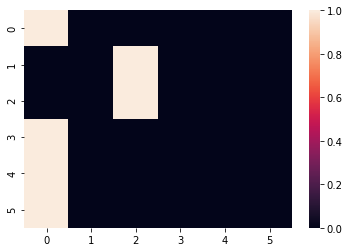

In [252]:
cm=confusion_matrix(test_y1_label,yhat1_label)
sns.heatmap(cm)

In [253]:
mean_squared_error(test_y2, yhat2)

4.7393488257367835

In [254]:
prediction_class, prediction_reg = model.predict(np.array([train_X[0]]))

In [255]:
label_accuracy_percent = prediction_class.max() * 100
label = expression_Label_encoder.inverse_transform(prediction_class.argmax(axis=1))[0]
print(label, label_accuracy_percent)

anger 43.29364597797394


In [256]:
prediction_reg[0][0]

7.5645514

In [257]:
rgb_frame = plt.imread("dataset\labeledframes\sad\S12_170.jpg")
gray_frame = convert_to_gray_scale([rgb_frame])
resized_frame = resize_image(gray_frame, img_w, img_h)
(prediction_class, prediction_reg) = model.predict(resized_frame)
print(prediction_class, prediction_reg)
label_accuracy_percent = prediction_class.max() * 100
label = expression_Label_encoder.inverse_transform(prediction_class.argmax(axis=1))
age = prediction_reg[0][0]
print(label_accuracy_percent)
print(label)
print(age)

[[0.000000e+00 7.707415e-30 0.000000e+00 6.048789e-30 4.339560e-16
  1.000000e+00 0.000000e+00]] [[18.82404]]
100.0
['sad']
18.82404


In [258]:
rgb_frame = plt.imread("dataset\labeledframes\sad\S12_170.jpg")
gray_frame = convert_to_gray_scale([rgb_frame])
resized_frame = resize_image(gray_frame, img_w, img_h)
prediction_class, prediction_reg = model.predict(resized_frame)
print(expression_Label_encoder.classes_)
print(prediction_class, prediction_reg)
label_accuracy_percent = prediction_class.max() * 100
label = expression_Label_encoder.inverse_transform(prediction_class.argmax(axis=1))
age = prediction_reg[0][0]
print(label_accuracy_percent)
print(label)
print(age)

['anger' 'confusing' 'disgust' 'fear' 'happy' 'sad' 'surprise']
[[0.000000e+00 7.707415e-30 0.000000e+00 6.048789e-30 4.339560e-16
  1.000000e+00 0.000000e+00]] [[18.82404]]
100.0
['sad']
18.82404
